# Image Thresholding

We load the initial image as below:

In [18]:
img_initial = cv2.imread('TEM.png')

First, we show the histogram of the image using the compute histogram function we already developed in the previous part.

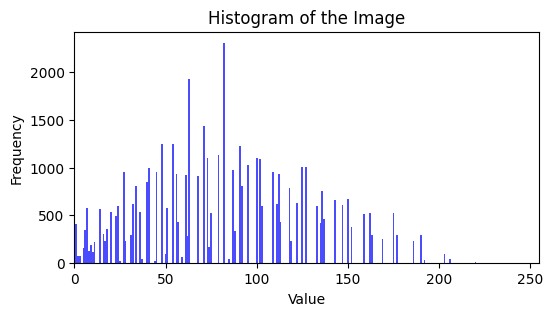

In [20]:
# Convert to grayscale
greyscale_img = cv2.cvtColor(img_initial, cv2.COLOR_BGR2GRAY)

# Compute histogram
hist = compute_histogram(greyscale_img.flatten(), bins=256, range=(0, 256), density=False)

# Define the bin edges for histogram, 256 bins from 0 to 255
bin_edges = np.linspace(0, 256, 257)

# plot
plt.figure(figsize=(6, 3))
plt.bar(bin_edges[:-1], hist, width=(bin_edges[1] - bin_edges[0]), color='blue', alpha=0.7)
plt.title('Histogram of the Image')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim([0, 255])
plt.show()

We know that the histogram can provide insight into the distribution of pixel intensities, which is crucial for understanding how Otsu's and Niblack's methods function.

Next, we define a function to find the inter-class variance  for each possible threshold value from 0 to 255 for the grayscale, to threshold the image to distinguish between the foreground and background:

In each iteration, we count how many pixels in the image have a grayscale value less than or equal to the current threshold, and consider these pixels as the background. Similarly, we count the pixels with a value greater than the threshold, and consider them as the foreground.

In [22]:
def calculate_inter_class_variance(image):

    thresholds = np.arange(256)
    variances = []

    # We flatten the 2D image into a 1D array and calculate the total number of pixels in the image
    total_pixels = len(image.ravel())

    for threshold in thresholds:

        # Create mask and count pixels
        background = np.sum(image <= threshold)
        foreground = total_pixels - background


        # Calculate probabilities and means
        p_background = background / total_pixels if total_pixels != 0 else 0
        p_foreground = foreground / total_pixels if total_pixels != 0 else 0

        if background > 0:
            mean_background = np.mean(image[image <= threshold])
        else:
            mean_background = 0

        if foreground > 0:
            mean_foreground = np.mean(image[image > threshold])
        else:
            mean_foreground = 0

        # Calculate inter-class variance
        variance = p_background * p_foreground * (mean_background - mean_foreground) ** 2
        variances.append(variance)

    return variances

Next, we call the function to calculate the variances and find threshold with maximum variance:

In [23]:
variances = calculate_inter_class_variance(greyscale_img)
max_variance_idx = np.argmax(variances)
print(f"Optimal threshold: {max_variance_idx}")

Optimal threshold: 85


Plotting the inter-class variance:

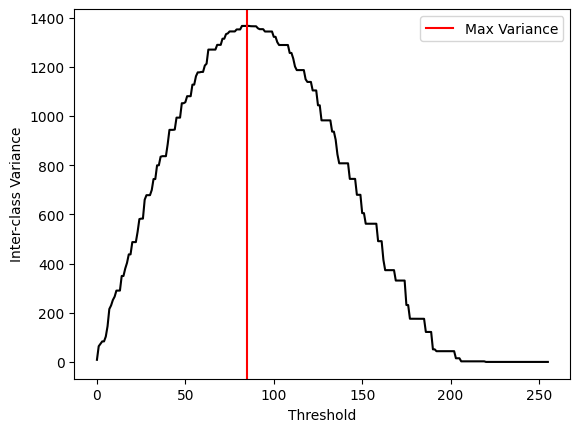

In [24]:
plt.figure()
thresholds = np.arange(256)
plt.plot(thresholds[:len(variances)], variances, color='black')
plt.axvline(x=max_variance_idx, color='red', label='Max Variance')
plt.xlabel('Threshold')
plt.ylabel('Inter-class Variance')
plt.legend()
plt.show()

Now that we have found the optimal threshold, we apply it to create the binary image, and plot it as below:

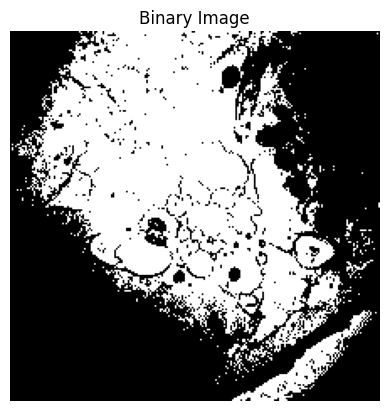

In [27]:
binary_image = np.zeros_like(greyscale_img)

# Apply the thresholding: set pixels above the threshold to white
binary_image[greyscale_img > max_variance_idx] = 255

# Plot binary image
plt.figure()
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.show()

Next, we implement Niblack thresholding algorithm in the below function:

This takes the window size and the k value as input. k adjusts how sensitive the threshold is to the local intensity variations, and we set it as -0.2 for our experiments.

Inside the function we compute the mean and variance over a sliding window for each pixel in the image, and then compute the Niblack threshold for each pixel to create a binary image

In [ ]:
def niblack_thresholding(image, window_size, k=-0.2):

    # Padding the image to handle the window
    pad_size = window_size // 2
    padded = np.pad(image, pad_size, mode='reflect')

    # empty arrays for the mean and std
    mean = np.zeros_like(image, dtype=np.float32)
    std = np.zeros_like(image, dtype=np.float32)

    # Sliding window to calculate mean and std
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):

            # Extract the window
            window = padded[i:i + window_size, j:j + window_size]

            # mean and standard deviation
            local_mean = np.mean(window)
            local_std = np.std(window)

            mean[i, j] = local_mean
            std[i, j] = local_std

    # Niblack threshold
    threshold = mean + k * std

    # binary image
    binary_image = image > threshold

    return binary_image

Now we check the above function for 3 different window sizes, and plot thresholded binary images for different window sizesas below:

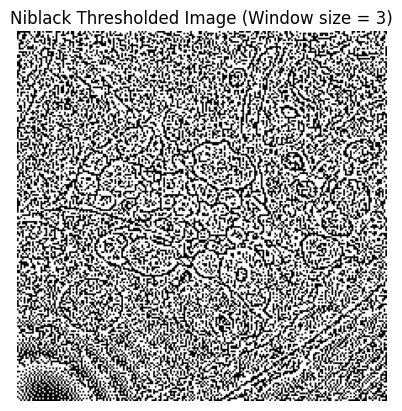

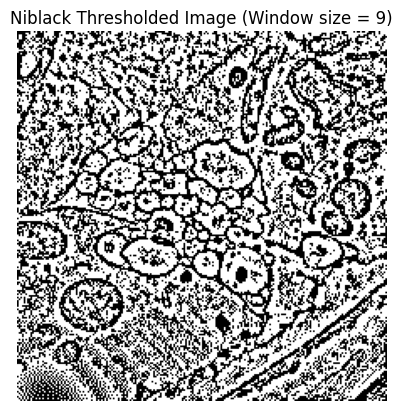

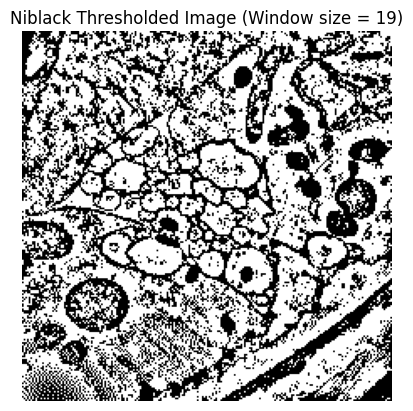

In [ ]:
window_sizes = [3, 9, 19]

# Apply Niblack thresholding
binary_images = []
for window_size in window_sizes:
    binary_img = niblack_thresholding(greyscale_img, window_size=window_size, k=-0.2)
    binary_images.append(binary_img)


# Plot binary images
for i, window_size in enumerate(window_sizes):
    plt.imshow(binary_images[i], cmap='gray')
    plt.title(f'Niblack Thresholded Image (Window size = {window_size})')
    plt.axis('off')
    plt.show()

### *Comparison:*

In general, Niblack's method adapts to local variations, which makes it potentially more robust for images with varying brightness or complex structures, but these results can vary significantly with filter size, which is a critical parameter to tune.

The window size controls how local statistics are calculated, particularly the mean and standard deviation, which determine the threshold for each pixel.

On the other hand, Otsu’s thresholding produces a global binary threshold, which effectively separates the main regions (background vs. foreground), but it misses details and may incorrectly binarize regions with similar intensities. As we can see, the result shows large homogenous areas with boundaries.

Overall, Otsu does not adapt the threshold locally but determines an optimal global threshold based on image histogram variance.